In [353]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers, constraints
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from preprocessing import _resample_group
import joblib
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

Data Preparation

In [354]:
# scalers
mr_scaler = joblib.load("scalers/mr_scaler.pkl")
p_scaler = joblib.load("scalers/p_scaler.pkl")
rho_scaler = MinMaxScaler(feature_range=(0, 0.1))

In [355]:
# this is our "observed" mr relation
observed_mr = pd.read_csv("dataframes/sample_mr.csv").query("ID == 15033").sort_values("M")

# define target masses between 1.0 and 2.25 M⊙
m_targets = np.linspace(1, 2.25, 11)

# for each target mass, pick the closest real row
observed_mr = observed_mr.iloc[np.abs(observed_mr["M"].values[:, None] - m_targets).argmin(axis=0)]
observed_mr = observed_mr.reset_index(drop=True)

MR_obs_np = np.column_stack((observed_mr["M"].values, observed_mr["R"].values))

# Scale both together
MR_obs_scaled = mr_scaler.transform(MR_obs_np)

# Split them back if needed
M_obs = tf.constant(MR_obs_scaled[:, 0], dtype=tf.float32)
R_obs = tf.constant(MR_obs_scaled[:, 1], dtype=tf.float32)

dM = tf.constant([1.0] * len(M_obs), dtype=tf.float32)
dR = tf.constant([1.0] * len(R_obs), dtype=tf.float32)

In [356]:
true_eos = pd.read_csv("dataframes/sample_eos.csv").query("ID == 15033").sort_values("rho")
true_eos['rho'] = true_eos['rho'] / 0.16
data = true_eos.sort_values('rho').reset_index(drop=True)

density_filter = np.linspace(1, 7.4, 32)

chosen = []
df_temp = data.copy()
for t in density_filter :
    proposed_idx = (df_temp['rho'] - t).abs().idxmin()
    chosen.append(proposed_idx)
    df_temp = df_temp.drop(proposed_idx)
resampled = data.iloc[chosen].reset_index(drop=True)
resampled.index = range(len(resampled))

data = resampled.copy(deep=True)

EOS Network

In [357]:
def build_eos_network(input_length=32, input_channels=1, output_channels=1):
    """
    Builds the EoS Network as described:
    - 3 Conv1D layers (kernel size = 1)
    - 2 hidden layers (64 filters each)
    - He normal initialization
    - L2 regularization (λ = 1e-8)
    - Same padding
    - NON-NEGATIVE WEIGHTS constraint
    """

    inputs = layers.Input(shape=(input_length, input_channels))

    x = layers.Conv1D(
        filters=64,
        kernel_size=1,
        padding="same",
        activation="elu",           
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(1e-8),
        kernel_constraint=constraints.NonNeg(),
        bias_constraint=constraints.NonNeg()
    )(inputs)

    x = layers.Conv1D(
        filters=64,
        kernel_size=1,
        padding="same",
        activation="elu",
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(1e-8),
        kernel_constraint=constraints.NonNeg(),
        bias_constraint=constraints.NonNeg()
    )(x)

    # Output layer
    outputs = layers.Conv1D(
        filters=output_channels,
        kernel_size=1,
        padding="same",
        activation="sigmoid",
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(1e-8),
        kernel_constraint=constraints.NonNeg(),
        bias_constraint=constraints.NonNeg()
    )(x)

    model = models.Model(inputs, outputs, name="EoS_Network")

    return model

In [358]:
tov_solver = load_model("models/tov_solver.h5", compile=False)
tov_solver.trainable = False            


# density -> pressure -> (M,R)
model = build_eos_network()
rho_input = tf.keras.Input(shape=(32,1), name='density_input')
pred_pressure = model(rho_input)
pred_mr = tov_solver(pred_pressure)   # frozen network
combined_model = tf.keras.Model(inputs=rho_input, outputs=pred_mr)

In [359]:
def chi2_loss(M_obs, R_obs, dM, dR):
    def loss(y_true, y_pred):
        # mr_pred: (1, N_rho, 2) -> squeeze to (N_rho, 2)
        mr_seq = tf.squeeze(y_pred, axis=0)          # (N_rho, 2)
        M_seq, R_seq = mr_seq[:,0], mr_seq[:,1]       # (N_rho,), (N_rho,)

        # For each observed point, find argmin over the sequence (vectorized)
        # distance^2 weighted by uncertainties (Eq. 4.2)
        # shapes: broadcast to (N_obs, N_rho)
        M_d2 = tf.square((M_seq[tf.newaxis,:] - M_obs[:,tf.newaxis]) / dM[:,tf.newaxis])
        R_d2 = tf.square((R_seq[tf.newaxis,:] - R_obs[:,tf.newaxis]) / dR[:,tf.newaxis])
        d2 = M_d2 + R_d2

        # Closest indices per observation
        idx = tf.argmin(d2, axis=1, output_type=tf.int32)     # (N_obs,)

        # Gather matched points and compute χ² (Eq. 4.1)
        M_matched = tf.gather(M_seq, idx)
        R_matched = tf.gather(R_seq, idx)
        chi2 = tf.reduce_sum(tf.square((M_matched - M_obs)/dM) + tf.square((R_matched - R_obs)/dR))
        
        return chi2
    return loss

In [360]:
loss_fn = chi2_loss(M_obs, R_obs, dM, dR)

def lr_schedule(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 200:
        return 0.005
    elif epoch < 350:
        return 0.003
    elif epoch < 510:
        return 0.0001
    else:
        return 0.00003

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

Epoch 1/1000
1/1 - 1s - 1s/step - loss: 1.7043 - learning_rate: 1.0000e-03
Epoch 2/1000
1/1 - 0s - 35ms/step - loss: 1.2346 - learning_rate: 1.0000e-03
Epoch 3/1000
1/1 - 0s - 34ms/step - loss: 1.1391 - learning_rate: 1.0000e-03
Epoch 4/1000
1/1 - 0s - 34ms/step - loss: 1.0348 - learning_rate: 1.0000e-03
Epoch 5/1000
1/1 - 0s - 33ms/step - loss: 0.9294 - learning_rate: 1.0000e-03
Epoch 6/1000
1/1 - 0s - 34ms/step - loss: 0.8266 - learning_rate: 1.0000e-03
Epoch 7/1000
1/1 - 0s - 34ms/step - loss: 0.7279 - learning_rate: 1.0000e-03
Epoch 8/1000
1/1 - 0s - 36ms/step - loss: 0.6352 - learning_rate: 1.0000e-03
Epoch 9/1000
1/1 - 0s - 34ms/step - loss: 0.5485 - learning_rate: 1.0000e-03
Epoch 10/1000
1/1 - 0s - 34ms/step - loss: 0.4700 - learning_rate: 1.0000e-03
Epoch 11/1000
1/1 - 0s - 34ms/step - loss: 0.3997 - learning_rate: 1.0000e-03
Epoch 12/1000
1/1 - 0s - 34ms/step - loss: 0.3211 - learning_rate: 1.0000e-03
Epoch 13/1000
1/1 - 0s - 36ms/step - loss: 0.2353 - learning_rate: 1.0000e-

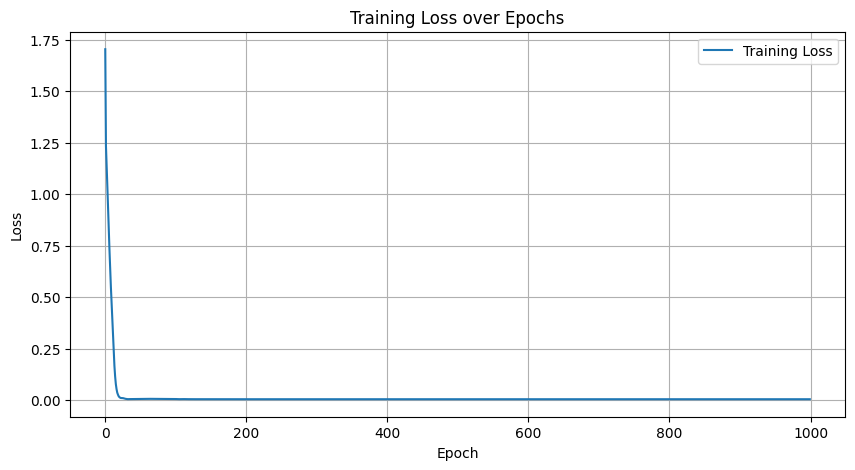

In [361]:
combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss_fn
)

X = np.zeros((1, 32, 1), dtype=np.float32)
X_scaled = rho_scaler.fit_transform(data['rho'].values.reshape(-1, 1)).reshape(X.shape)

history = combined_model.fit(
    X_scaled,
    np.zeros((len(X_scaled), 2)),  # dummy target
    epochs=1000,
    batch_size=1,
    verbose=2,
    callbacks=[lr_callback]
)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


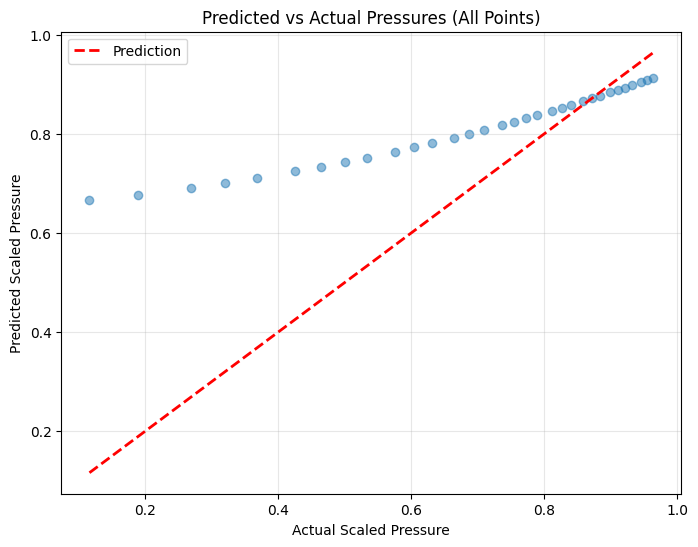

In [362]:
p_pred = model.predict(X_scaled)
p_actual_scaled = p_scaler.transform(np.log10(np.clip(data['p'].values, 1e-30, None)).reshape(-1, 1))

# Flatten both arrays for plotting
p_pred_flat = p_pred.flatten()
p_actual_flat = p_actual_scaled.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(p_actual_flat, p_pred_flat, alpha=0.5)
plt.plot([p_actual_flat.min(), p_actual_flat.max()], 
         [p_actual_flat.min(), p_actual_flat.max()], 
         'r--', linewidth=2, label='Prediction')
plt.xlabel('Actual Scaled Pressure')
plt.ylabel('Predicted Scaled Pressure')
plt.title('Predicted vs Actual Pressures (All Points)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


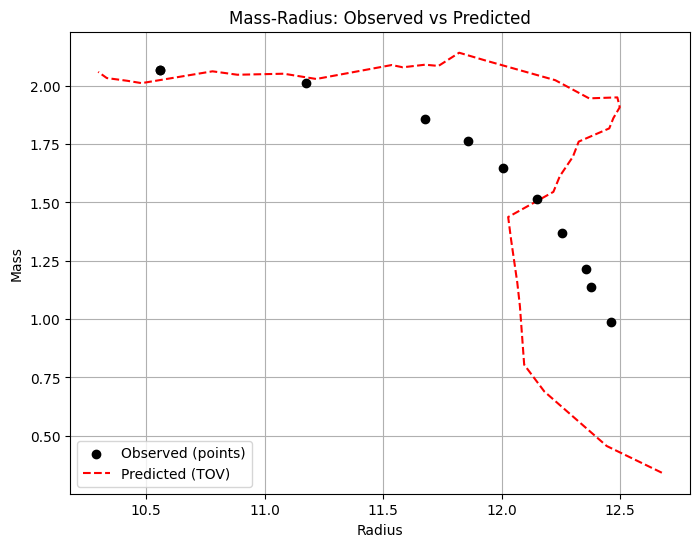

In [363]:
mr_relation_pred = combined_model.predict(X_scaled)

# Inverse-transform predicted M-R back to physical units using mr_scaler
mr_pred_flat = mr_relation_pred.reshape(-1, 2)  # (32, 2)
mr_pred_unscaled = mr_scaler.inverse_transform(mr_pred_flat)
mass_pred = mr_pred_unscaled[:, 0]
radius_pred = mr_pred_unscaled[:, 1]

# Observed M-R (physical units) from obs_df (radius on x-axis)
mass_obs = observed_mr['M'].values
radius_obs = observed_mr['R'].values

# Plot observed and predicted M-R relation
plt.figure(figsize=(8,6))
plt.scatter(radius_obs, mass_obs, color='black', label='Observed (points)', zorder=3)
plt.plot(radius_pred, mass_pred, color='red', linestyle='--', label='Predicted (TOV)', zorder=2)
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.title('Mass-Radius: Observed vs Predicted')
plt.legend()
plt.grid(True)
plt.show()